# <center> Assignment 4: Is a Picture Worth a Thousand Words? </center>
## <center> Matt Viteri, Abhilash Gupta, Stephen Darasimi Oluwaniyi, Colin Chu </center>

In [1]:
import pandas as pd
import numpy as np
from google.cloud import vision
import os
import nltk
import gensim
import pyLDAvis
import pyLDAvis.gensim
import json
import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords');

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="APAD-DARASIMI-8c1a66d445ac.json"
client = vision.ImageAnnotatorClient()
image = vision.types.Image()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abhivik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import seaborn as sns
import json
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedKFold

## Task 0. 

On Instagram, choose the National Geographic (natgeo) page (do not use hashtags). Write a
scraper or use the Web Scraper to extract 
- Image URLs (do not extract video URLs, it may end up costing you a lot of money to run analytics on video)
- Post caption (the text description of a post)
- Number of likes
- Number of comments (You don’t need actual comments for this assignment)
- Scrape around 400-500 image posts. 

Using the image URLs, obtain image labels from Google Vision cloud (you will have to create an
account with Google to get your credentials as a json file, though the first $300 are free, which
should be more than plenty for this assignment)
- You will need to write a script to access the Google Vision API.

In [2]:
## See scraper in attached file
data = pd.read_csv("output.csv")
data.head()

,type,media_url,caption,likes,comments
0,GraphImage,https://scontent-ort2-1.cdninstagram.com/v/t51...,"Photo by @jasperdoest | Penguins, like other b...",123736,697
1,GraphImage,https://scontent-ort2-1.cdninstagram.com/v/t51...,Photo by William Albert Allard @williamalberta...,176725,343
2,GraphImage,https://scontent-ort2-1.cdninstagram.com/v/t51...,Photo by Katie Orlinsky @katieorlinsky | A you...,205613,859
3,GraphImage,https://scontent-ort2-1.cdninstagram.com/v/t51...,Photo by Trevor Frost @tbfrost | Snakes in car...,188741,920
4,GraphImage,https://scontent-ort2-1.cdninstagram.com/v/t51...,Photo by Michael Melford @michaelmelford | An ...,293077,589


## Task A. 

Create a metric for engagement by using a weighted sum of # likes and # comments. 
- First normalize # likes and # comments such that they both have values between 0 and 1. You can scale the # likes by dividing by the maximum # likes (for a post) in your data and do the same for # comments, so that # likes and comments will be in the range [0,1]
- Now create an <b> engagement score = .4*# likes (normalized) + .6*# comments (normalized) </b>
- Define High (1) and Low (0) engagement based on whether the engagement score is above or below the median value

### Normalizing Likes & Comments

In [3]:
Likes = data['likes']
Norm_Likes = (Likes-Likes.min())/(Likes.max()-Likes.min())
print(Norm_Likes.head())
print("The range of Norm_Likes is between %i and %i"%(Norm_Likes.max(),Norm_Likes.min()))
print()
Comments = data['comments']
Norm_Comments = (Comments-Comments.min())/(Comments.max()-Comments.min())
print(Norm_Comments.head())
print("\n The range of Norm_Comments is between %i and %i"%(Norm_Comments.max(),Norm_Comments.min()))

0    0.000338
1    0.035831
2    0.055181
3    0.043879
4    0.113766
Name: likes, dtype: float64
The range of Norm_Likes is between 1 and 0

0    0.036970
1    0.009301
2    0.049633
3    0.054401
4    0.028529
Name: comments, dtype: float64

 The range of Norm_Comments is between 1 and 0


### Engagement Score

In [4]:
Engagement_Score = 0.4*Norm_Likes + 0.6*Norm_Comments
Engagement_Median = Engagement_Score.median()

### Determine Engagement [ 1 or 0 ] base on Engagement Score

In [5]:
Engagement = Engagement_Score.apply(lambda x: 1 if x >= Engagement_Median else 0)

In [6]:
data['Norm_Likes'] = Norm_Likes
data['Norm_Comments'] = Norm_Comments
data['Engagement_Score'] = Engagement_Score
data['Engagement'] = Engagement

In [7]:
data.to_csv('TaskA.csv', index=False)

In [8]:
## Getting the image labels

def detect_labels_uri(uri):
    """Detects labels in the file located in Google Cloud Storage or on the
    Web."""
    image.source.image_uri = uri
    response = client.label_detection(image=image)
    labels = response.label_annotations
    label_description = []
    for label in labels:
        label_description.append(label.description)
    return label_description

In [9]:
df = pd.read_csv('TaskA.csv')

In [10]:
df["image_labels"] = df["media_url"].apply(lambda x: detect_labels_uri(x))

In [11]:
df = df[['type','media_url','image_labels','caption','likes','comments','Norm_Likes','Norm_Comments','Engagement_Score','Engagement']]

In [12]:
df.to_csv('image_labels.csv', index=False)

## Task B

Run a logistic regression with Engagement (binary) as the dependent variable, and the
image labels as independent variables. 
- What is the accuracy (show the confusion matrix)?
- What accuracy do you get by using the post caption words as the independent variables instead of image labels?
- Finally, what accuracy do you get by combining the image labels and post captions and using them as independent variables? What can you conclude from your analysis?
- Note: Doing a word frequency analysis and word replacement on the image labels as well as captions will increase the accuracy of prediction. Needless to say, TF-IDF scores should be used. 

In [3]:
df = pd.read_csv('image_labels.csv')

In [4]:
same_map = {
    'Terrestrial animal':  ['Bengal tiger', 'Siberian Tiger','Big cats','Giraffidae',
                               'Giraffe', 'Giraffidae','Felidae','Panda','Bear','Fur','Lycaon pictus','Canidae','Snout'
                               'Antler','Barren ground Caribou','Deer','Black rhinoceros','Black-footed ferret','Bull','Burmese python',
                                'Python','Burro','Dog','Dog breed','Elk','Fawn','Ferret','Frog','Hognose snake','Indian elephant','Indian rhinoceros',
                                'Mare','Mustelidae','Mustelinae','Python','Python family','Reindeer',
                               'Rhinoceros','Sloth','Stoat','Suidae','Three-toed sloth',
                               'Warthog','Weasel','White rhinoceros','polecat','African elephant','Arabian camel','Bovine','Camel',
                                'Camelid','Elapidae','Elephants and Mammoths','Elephants','Hunting dog','Hyena','Irish wolfhound',
                                'Mane','Scaled reptile','Serpent','Snake','Masai lion','Lion'
                               ],
    'Music': ['Accordion','Accordionist','Diatonic button accordion','Concertina','Folk instrument','Free reed aerophone',
             'Trikiti','Garmon'],
    'Sky' : ['Cumulus','Cloud'],
    'Volant animal' : ['Budgie','Lovebird','Macaw','Parrot','Pelican','Ciconiiformes','Stork','Wing','Seabird',
                      'Flightless bird','Bird'],
    'Wildlife': ['Dinosaur','Grazing','Phyllobates','Poison dart frog','Tyrannosaurus','Velociraptor','Pack animal','Jungle'],
    'Aquatic animal' :  ['Cartilaginous fish','Fish','Manta ray','Marine biology','Rays and skates','Skate','Amphibian',
                        'Bull shark','Carcharhiniformes','Deep sea fish','Great white shark','Green sea turtle',
                        'Hairfinned silverfish','Humpback whale','Hawksbill sea turtle',"Kemp's ridley sea turtle",
                        'Loggerhead sea turtle','Manta ray','Olive ridley sea turtle','Requiem shark','Sea turtle',
                        'Shark','Stingray','Tiger shark','Toad','Whale','grey whale','Cetacea','Earless seal','Fin','Fur seal',
                        'Harbor seal','Seal','Water bird','Emperor penguin''Gentoo penguin','Penguin','Marine mammal' ],
    'Animal' :['Carnivore','Mammal','Organism','Flesh','Cheek','Climbing','Eating','Herder','Hip','Hug','Knee','Mouth',
              'Skeleton','Tail','Turtle','Claw','Chin','Male','Reptile','Beak','Skin','Vertebrate'],
    'Nature': ['Night','Underwater','Cloud','Darkness','Space','Mud','Safari','Natural environment',
              'Field','Savanna','Groundcover','Atmosphere','Atmospheric phenomenon',
              'Wind','Star','Afterglow','Bedrock','Bird migration','Birth','Cave','Cliff','Coastal and oceanic landforms',
              'Dirt road','Extinction','Family','Fire','Flame','Flock','Floor','Fog','Fossil','Harvest','Harvester',
              'Heat','Ice cave','Interaction','Lava tube','Magenta','Massif',
              'Metal','Mist','Outcrop','Pasture','Steppe','Stratovolcano','Summit','Sunrise','Tide','Tundra',
              'Volcanic landform','Volcano','Wadi','Dune','Erg','Iceberg','Rainforest','Aeolian landform','Desert',
              'Highland','Sahara','Ecoregion','Snow','Wilderness','Organism','Rock','Mountain'],
    
    'Plant' :['Crop','Woody plant','Tree','Grass','Grassland','Plantation','Green','Branch','Lawn','Attalea speciosa','Desert Palm',
             'Borassus flabellifer','Borassus flabellifer','Elaeis','Flower','Fungus','Groundcover','Terrestrial plant','Arecales'
             'Cash crop','Date palm','Soil','Vegetation','Leaf'
             ],
    'Architecture':     ['Building','Door','Room','Stairs','Wall','Landmark','Tower','Spire','Finial','Bridge','Cityscape',
                        'Holy places','Hospital','Museum','Statue','Village','Vineyard'],
    'Aquatic': ['Arctic','Arctic ocean','Blue','Glacial landform','Glacier','Ice','Ice cave','Iceberg','Polar ice cap',
               'Boat','Sail','Sailing ship','Sailing','Sea','Tall ship','Watercraft','Water','Aqua','Diving equipment','Dike',
               'Coral','Coral reef','Harbor','Reef','Sea ice','Tarn','Pond','Arctic ocean','River','Ocean','Water'],
    'Human element': ['Vacation','Street fashion','Human body','Human','Artificial turf','Shoe','Bed sheet',
                     'Basketball','Bedroom','Blazer','Bow tie','Bride','Bridle','Caving',
                      'Cheerleading','Clinic','Cooling tower','Dance','Electrical supply','Electricity','Explosion',
                     'Fashion accessory','Fiction','Fictional character','Flare','Flash photography','Flip (acrobatic)',
                     'Flooring','Footwear','Gardener','Gentleman','Gown','Grandparent','Halter','Head restraint',
                     'Headpiece','Horse harness','Horse supplies','Horse tack','Human leg','Human settlement',
                     'Knitting','Living room','Love','Metropolis','Metropolitan area','Military person','Music venue',
                     'National park','Net','Personal protective equipment','Scuba diving','Garden',
                     'Military camouflage','Military organization','Military uniform'],
    'Food' : ['Comfort food','Meal','Restaurant','Agriculture','Bread','Bun'],
    'Furniture' : ['Bed','Chair','Coffee table','Compact car','Fan','Hospital bed'],
    'Photography' : ['Lens flare','Screenshot','Reflection','Scene','Digital compositing','Collage','Colorfulness',
                    'Photo shoot','Portrait photography','Visual effect lighting','Wallpaper','Visual arts'],
    'Transportation' :['Bicycle drivetrain part','Bicycle wheel','Car','Carriage','Vehicle','Family car','Horse and buggy',
                      'Mid-size car','Wagon','Watercraft','Bicycle',],
    'Technology': ['Display device','Electronic device','Squeezebox'],
    'Weapons' :['Airsoft','Gun','Shotgun','Gunfighter']
}

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [6]:
def get_split_char(caption):
    if '@simonnorfolkstudio' in caption:
        return 'I'
    elif '@dguttenfelder' in caption:
        return '//'
    else:
        return '|'

def cut_n_trailing_words(words):
    count = 0
    for word in reversed(words):
        if word == '' or word[0] == '#' or word[0] == '@' or word.endswith('2063#tehran'):
            count += 1
        else:
            break
    return count
    
def clean(caption):
    try:
        v1 = ' '.join(caption.split(get_split_char(caption))[1:]).strip()
    except Exception as e:
        print(caption)
        print(e)
    v2 = v1[:-3] if v1.endswith('}}]') else v1
    v3 = v2.replace('\\n', ' ').replace('\\', '\'').replace('//', '')
    v3_split = [lemmatizer.lemmatize(ps.stem(x)) for x in v3.split(' ') if (x != '' and x not in stop_words)]
    v3_cutoff = -1 * cut_n_trailing_words(v3_split)
    v4 = ' '.join(v3_split[:v3_cutoff]) if v3_cutoff != 0 else ' '.join(v3_split)
    return v4

cleaned_captions = [clean(c) for c in df['caption']]

In [7]:
joined_cleaned_captions = ' '.join(cleaned_captions)

In [8]:
def splitter(data):
    words = re.sub("([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", data.lower()).split()
    return [word for word in words]

In [9]:
caption_words = splitter(joined_cleaned_captions)

In [10]:
same_inv_map = {word: root for root, words in same_map.items() for word in words}

In [11]:
def convert_same_all(words):
    return [convert_same(word) for word in words]

def convert_same(word):
    return same_inv_map[word] if word in same_inv_map else word

caption_words_converted = convert_same_all(caption_words)
selected_words = np.intersect1d(np.array([]).tolist(), caption_words_converted)
Counter(caption_words_converted).most_common(20)

[('i', 178),
 ('woman', 144),
 ('the', 129),
 ('photograph', 108),
 ('follow', 107),
 ('for', 96),
 ('world', 95),
 ('women', 91),
 ('stori', 84),
 ('one', 74),
 ('life', 74),
 ('use', 71),
 ('it', 66),
 ('like', 64),
 ('next', 63),
 ('a', 62),
 ('week', 54),
 ('see', 52),
 ('imag', 51),
 ('nat', 51)]

In [12]:
df['image_labels_mapped'] = df['image_labels'].apply(lambda l: json.loads(l.replace('\'', '\"'))).apply(convert_same_all)
# use in place of above if an error occurs
# df['image_labels_mapped'] = df['image_labels'].map(convert_same_all)

In [13]:
def tf_idf(list_of_lists):
    words = [word for l in list_of_lists for word in l]
    words = [t[0] for t in Counter(words).most_common(100)]
    tf = pd.DataFrame(False, index=range(len(list_of_lists)), columns=words)
    
    for col in words:
        tf[col] = [l.count(col)/len(l) for l in list_of_lists]
    
    number_of_docs = len(list_of_lists)
    
    idf = (tf
        .applymap(lambda v: v != 0)
        .sum(axis='rows')
        .apply(lambda v: np.log(number_of_docs/v)))
    
    return pd.DataFrame([np.multiply(row.tolist(), idf.tolist()) for _, row in tf.iterrows()])
    

tf_idf_df = tf_idf(df['image_labels_mapped'])
X = tf_idf_df.values
y = df['Engagement'].values

Accuracy score (image labels only): 0.6805555555555556


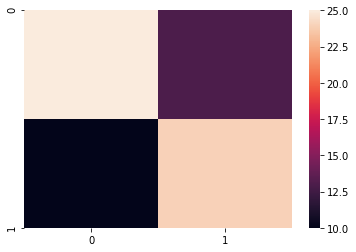

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

model = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy score (image labels only):', accuracy_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred));

In [19]:
#adding over selected words for each image
X = tf_idf(df['image_labels_mapped'].map(lambda v: v + selected_words.tolist()))

Accuracy score (captions & image labels): 0.7586206896551724


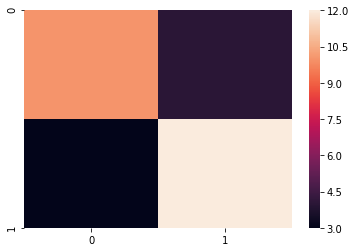

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)

model = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy score (captions & image labels):', accuracy_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred));

## Task C
Perform topic modeling (LDA) on the image labels. Choose an appropriate number of topics. 
- You may want to start with 5, but adjust the number up or down depending on the word distributions you get
- LDA should produce two outputs: 
    - A file showing which words load on which topics
    - A file showing topic weights for each image. 

In [13]:
NUMBER_OF_TOPICS = 5 

In [15]:
df = pd.read_csv('image_labels.csv')
df['image_labels'] = df['image_labels'].apply(lambda l: json.loads(l.replace('\'', '\"')))

texts = df['image_labels'].tolist()
id2word = gensim.corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=NUMBER_OF_TOPICS, 
                                           random_state=9,
                                           update_every=1,
                                           chunksize=25,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.030*"Geological phenomenon" + 0.028*"Atmospheric phenomenon" + 0.024*"Bird" + 0.024*"Wildlife" + 0.022*"Headgear" + 0.020*"Winter" + 0.020*"Beak" + 0.016*"Snow" + 0.016*"Carnivore" + 0.015*"Natural environment"'),
 (1,
  '0.055*"Sky" + 0.051*"Tree" + 0.040*"Photography" + 0.036*"Plant" + 0.029*"Wildlife" + 0.027*"Night" + 0.024*"Water" + 0.021*"Landscape" + 0.018*"Adaptation" + 0.018*"Rock"'),
 (2,
  '0.038*"Event" + 0.032*"Fun" + 0.032*"People" + 0.031*"Art" + 0.031*"Tourism" + 0.027*"Child" + 0.027*"Crowd" + 0.026*"Leisure" + 0.023*"Lady" + 0.018*"Temple"'),
 (3,
  '0.037*"Adaptation" + 0.035*"Human" + 0.028*"Room" + 0.027*"Terrestrial animal" + 0.018*"Vertebrate" + 0.018*"Vehicle" + 0.016*"Grassland" + 0.015*"Mammal" + 0.014*"Snout" + 0.013*"Grass"'),
 (4,
  '0.042*"Sky" + 0.041*"Sea" + 0.036*"Water" + 0.032*"Blue" + 0.030*"Cloud" + 0.027*"Photography" + 0.023*"Ocean" + 0.021*"Vacation" + 0.019*"Horizon" + 0.016*"Fun"')]

In [16]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.234528 -0.062913       1        1  29.727577
4      0.131547  0.069502       2        1  20.069576
3     -0.156971 -0.186799       3        1  19.886967
2     -0.123671  0.217428       4        1  16.781137
0     -0.085432 -0.037218       5        1  13.534741, topic_info=    Category       Freq                 Term      Total  loglift  logprob
60   Default  38.000000                 Tree  38.000000  30.0000  30.0000
42   Default  63.000000                  Sky  63.000000  29.0000  29.0000
59   Default  21.000000                  Sea  21.000000  28.0000  28.0000
58   Default  27.000000                Plant  27.000000  27.0000  27.0000
66   Default  44.000000          Photography  44.000000  26.0000  26.0000
..       ...        ...                  ...        ...      ...      ...
100   Topic5   5.242077  Natural environment  11.274032   1.2341  -4.1790
68    Topic5   8.184216             Wildlife  30.502708   0.6843  -3.7335
152   Topic5   4.769966               Mammal  12.748026   1.0169  -4.2733
192   Topic5   4.327503           Vertebrate  13.942394   0.8300  -4.3707
92    Topic5   3.909631             Mountain  13.483090   0.7619  -4.4722

[215 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
55        1  0.429681      Adaptation
55        3  0.552448      Adaptation
683       5  0.675512   Animal sports
118       2  0.519208    Architecture
118       3  0.445035    Architecture
...     ...       ...             ...
29        5  0.925482          Winter
62        1  0.970846            Wood
189       1  0.948095     Woody plant
18        1  0.878606  Working animal
244       4  0.834952           Youth

[189 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

In [17]:
c1 = pd.DataFrame([(topic, [id2word[t[0]] for t in lda_model.get_topic_terms(topic)]) for topic in range(NUMBER_OF_TOPICS)])
c1.to_csv('TaskCi.csv', header=False, index=False)

In [18]:
def get_topic_weights(corpus):
    result = pd.DataFrame(0, columns=range(NUMBER_OF_TOPICS), index=range(len(corpus)))
    for index, scores in result.iterrows():
        for score in lda_model.get_document_topics(corpus[index]):
            result.iloc[index, score[0]] = score[1]
    return result

c2 = get_topic_weights(corpus)

c2.to_csv('TaskCii.csv')

In [19]:
def get_avg_weights(df):
    corpus1 = [id2word.doc2bow(text) for text in df['image_labels'].tolist()]
    weights1 = get_topic_weights(corpus1)
    return weights1.sum()/weights1.shape[0]

df1, df2, df3, df4 = np.array_split(df.sort_values(by='Engagement_Score', ascending=False), 4)

scores1 = get_avg_weights(df1)
scores4 = get_avg_weights(df4)
data = zip(range(NUMBER_OF_TOPICS), c1[1], scores1.tolist(), scores4.tolist(), (scores1-scores4).tolist())

pd.set_option('display.max_colwidth', -1)
end_result = pd.DataFrame(data, columns=['Topics', 'Words', 'Avg. top quartile weight', 'Avg. bottom quartile weight', 'Difference'])
end_result.set_index('Topics').sort_values(by='Difference', ascending=False)

,Words,Avg. top quartile weight,Avg. bottom quartile weight,Difference
Topics,,,,
0,"[Geological phenomenon, Atmospheric phenomenon, Bird, Wildlife, Headgear, Winter, Beak, Snow, Carnivore, Natural environment]",0.166165,0.078294,0.087871
1,"[Sky, Tree, Photography, Plant, Wildlife, Night, Water, Landscape, Adaptation, Rock]",0.314218,0.249967,0.064252
3,"[Adaptation, Human, Room, Terrestrial animal, Vertebrate, Vehicle, Grassland, Mammal, Snout, Grass]",0.250686,0.210128,0.040558
4,"[Sky, Sea, Water, Blue, Cloud, Photography, Ocean, Vacation, Horizon, Fun]",0.162730,0.152935,0.009795
2,"[Event, Fun, People, Art, Tourism, Child, Crowd, Leisure, Lady, Temple]",0.102300,0.303295,-0.200995


## Task D 

<b> What advice would you give National Geographic if it wants to increase engagement on its Instagram page based on your findings in Tasks B and C? </b> 

In order to increase overall engagement on National Geographic's Instagram page, we recommend to post more photos on nature phenomena. Our results from Task C support this as shown above in the table. Each topic shows the fraction of posts that are in the top and low quartile weight in terms of engagement. For example, this means that 16% of the top quartile posts in terms of engagement consist of photos based on geological phenomenons, wildlife, carnivores, and so on. On the other hand, 7% of the bottom quartile consist of photos of the same topic. The least popular posts seem to be those of events, people, tourism, crowds, and so on. Only 10% were part of the top quartile while 30% were on the bottom quartile. This means that people really dislike seeing posts of this type, as shown in the difference of 20%. Furthermore, as shown in Task B, the combined captions and image labels show a higher accuracy for predicting engagement rather than the only the image labels. Therefore, National Geographic should also focus on writing good, catchy captions that appeal to the audience rather than just credits or nothing at all. It would be best to tell a story with the captions in order to further engage and attract more of an audience. 

Clearly, people are more interested in seeing natural phenomena that they may not be able to see and/or engage in everyday life. Posts of carnivores, such as the Bengal Tiger, which are dangerous to see in real life and as such not very feasible to see in real life are popular. People also seem to be fascinated by atmospheric phenomenon such as a rainbow bridge or Aurora Borealis which may be hard to photograph for the average person or too far away to enjoy in person. People enjoy sights that are uncommon for them and may not be accesible for them in their daily lives. On the other hand, common sights such as tourism and crowds are highly unpopular perhaps due to the high frequency with which they appear in an average person's life. 

Perhaps, it would be best to hire photographers who are specialized in nature life and atmospheric phenomenon. For example, a potential photographer to hire would be Marc Adamus who is a famous landscape photographer who is famous for his dedication towards nature. His trips take weeks to months and he is well known for finding undiscovered locations. His photos show the dynamics of the landscape perfectly and fit right into the topic of geographical phenomena. Another potential photographer to hire is Art Wolfe who is famous for his stunning wildfire and environental images in the world. He has released over 65 photography books and has many famous photos of hard to photograph animals such as bears, tigers and eagles. Furthermore, his prestige could bring over more views and engagement for the National Geographic's Instagram page.